In [1]:

import os
import json
import warnings

import sklearn.linear_model

warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
%matplotlib inline

from tqdm.notebook import tqdm

In [2]:
def jsonl2df(fpath):
    with open(fpath, 'rt') as f:
        result = [json.loads(l) for l in f]
    df = pd.DataFrame(result)
    return df

event = jsonl2df('axie_financial_events_20210115_v2.jsonl')
item = jsonl2df('axie_item_metadata_v2.jsonl')
exchange = jsonl2df('erc20_exchange_rates.jsonl')

event = event[event.data_consistency_status=='complete']
event.block_timestamp = pd.to_datetime(event.block_timestamp)
item.block_timestamp =pd.to_datetime(item.block_timestamp)

In [3]:
dataset = pd.DataFrame()
auction_seller_event = event[(event.transaction_type=='auction')&(event.transaction_subtype=='matched')&(event.entity_type=='seller')]
auction_seller_event['sold_item_id'] = [x[0]['item_id'] for x in auction_seller_event.items_sent]
auction_seller_event['eth_price'] = [x[0]['received_eth'] for x in auction_seller_event.erc20s]
auction_seller_event['usd_price'] = [x[0]['received_usd'] for x in auction_seller_event.erc20s]
auction_seller_event = auction_seller_event[(auction_seller_event.columns.tolist()[:2]+auction_seller_event.columns.tolist()[-3:])]


In [4]:
dataset = pd.merge(auction_seller_event, item, left_on='sold_item_id', right_on='item_id')
dataset.reset_index(inplace=True, drop=True)

keep_idx=[]
for (idx_timestamp, idx_item_id), group in tqdm(dataset.groupby(['block_timestamp_x','sold_item_id']), total=dataset.groupby(['block_timestamp_x','sold_item_id']).ngroups):
    group['diff'] = abs(group.block_timestamp_x - group.block_timestamp_y)
    keep_idx.append(group['diff'].idxmin())

dataset = dataset.loc[keep_idx]
dataset = dataset.drop(['partition_id','block_timestamp_y','block_date','sold_item_id'], axis=1)

  0%|          | 0/129402 [00:00<?, ?it/s]

In [5]:
exchange = exchange[exchange.currency.isin(['ETH','SLP','AXS'])]
exchange = exchange[['block_date','currency','vs_currency','exchange_rate']]
exchange = pd.pivot(exchange, index='block_date', columns=['currency','vs_currency'])
exchange.reset_index(inplace=True)
exchange.columns = ['block_date','AXS_ETH','AXS_USD','ETH_ETH','ETH_USD','SLP_ETH','SLP_USD']

dataset['block_date'] = dataset.block_timestamp_x.dt.strftime('%Y-%m-%d')
dataset = pd.merge(dataset, exchange, on='block_date')
dataset.drop('block_date', axis=1, inplace=True)
dataset.item_id = [int(x[1]) for x in dataset.item_id.str.split('_')]


dataset.head()


,block_timestamp_x,eth_price,usd_price,item_id,father,fatherClass,mother,motherClass,class,stage,...,total_bionic_parts_count,is_having_mystic_part,is_having_xmas_part,is_having_bionic_part,AXS_ETH,AXS_USD,ETH_ETH,ETH_USD,SLP_ETH,SLP_USD
0,2018-03-25 11:13:35+00:00,0.957500,497.407462,521,0,NaN,0,NaN,bug,4,...,0,True,False,False,0.000363,0.1457,1.0,519.4856,0.000219,0.031432
1,2018-03-25 11:49:59+00:00,0.116815,60.683710,225,0,NaN,0,NaN,plant,4,...,0,False,False,False,0.000363,0.1457,1.0,519.4856,0.000219,0.031432
2,2018-03-25 12:06:44+00:00,0.143273,74.428016,224,0,NaN,0,NaN,aquatic,4,...,0,False,False,False,0.000363,0.1457,1.0,519.4856,0.000219,0.031432
3,2018-03-25 13:11:10+00:00,0.142883,74.225611,192,0,NaN,0,NaN,plant,4,...,0,False,False,False,0.000363,0.1457,1.0,519.4856,0.000219,0.031432
4,2018-03-25 13:11:10+00:00,0.430356,223.563925,235,0,NaN,0,NaN,aquatic,4,...,0,True,False,False,0.000363,0.1457,1.0,519.4856,0.000219,0.031432


In [6]:
dataset['eth_price'] = dataset['eth_price'].astype(float)
dataset['usd_price'] = dataset['usd_price'].astype(float)
dataset['father'] = dataset['father'].astype(int)
dataset['mother'] = dataset['mother'].astype(int)

dataset['stage'] = dataset['stage'].astype(int)
dataset['level'] = dataset['level'].astype(int)
dataset['exp'] = pd.to_numeric(dataset['exp'])

dataset['breedCount'] = dataset['breedCount'].astype(int)
dataset['breedable'] = dataset['breedable'].astype(bool)

dataset['skill'] = pd.to_numeric(dataset['skill'])
dataset['morale'] = pd.to_numeric(dataset['morale'])
dataset['speed'] = pd.to_numeric(dataset['speed'])
dataset['hp'] = pd.to_numeric(dataset['hp'])

dataset['all_parts_total_points'] = pd.to_numeric(dataset['all_parts_total_points'])

dataset['is_mouth_mystic'] = dataset['is_mouth_mystic'].astype(bool)
dataset['is_mouth_bionic'] = dataset['is_mouth_bionic'].astype(bool)
dataset['is_mouth_xmas'] = dataset['is_mouth_xmas'].astype(bool)
dataset['mouth_move_stage'] = pd.to_numeric(dataset['mouth_move_stage'])
dataset['mouth_move_total_points'] = pd.to_numeric(dataset['mouth_move_total_points'])
dataset['mouth_move_attack'] = pd.to_numeric(dataset['mouth_move_attack'])
dataset['mouth_move_defense'] = pd.to_numeric(dataset['mouth_move_defense'])
dataset['mouth_move_accuracy'] = pd.to_numeric(dataset['mouth_move_accuracy'])

dataset['is_horn_mystic'] = dataset['is_horn_mystic'].astype(bool)
dataset['is_horn_bionic'] = dataset['is_horn_bionic'].astype(bool)
dataset['is_horn_xmas'] = dataset['is_horn_xmas'].astype(bool)
dataset['horn_move_stage'] = pd.to_numeric(dataset['horn_move_stage'])
dataset['horn_move_total_points'] = pd.to_numeric(dataset['horn_move_total_points'])
dataset['horn_move_attack'] = pd.to_numeric(dataset['horn_move_attack'])
dataset['horn_move_defense'] = pd.to_numeric(dataset['horn_move_defense'])
dataset['horn_move_accuracy'] = pd.to_numeric(dataset['horn_move_accuracy'])



dataset['is_back_mystic'] = dataset['is_back_mystic'].astype(bool)
dataset['is_back_bionic'] = dataset['is_back_bionic'].astype(bool)
dataset['is_back_xmas'] = dataset['is_back_xmas'].astype(bool)
dataset['back_move_stage'] = pd.to_numeric(dataset['back_move_stage'])
dataset['back_move_total_points'] = pd.to_numeric(dataset['back_move_total_points'])
dataset['back_move_attack'] = pd.to_numeric(dataset['back_move_attack'])
dataset['back_move_defense'] = pd.to_numeric(dataset['back_move_defense'])
dataset['back_move_accuracy'] = pd.to_numeric(dataset['back_move_accuracy'])

dataset['is_tail_mystic'] = dataset['is_tail_mystic'].astype(bool)
dataset['is_tail_bionic'] = dataset['is_tail_bionic'].astype(bool)
dataset['is_tail_xmas'] = dataset['is_tail_xmas'].astype(bool)
dataset['tail_move_stage'] = pd.to_numeric(dataset['tail_move_stage'])
dataset['tail_move_total_points'] = pd.to_numeric(dataset['tail_move_total_points'])
dataset['tail_move_attack'] = pd.to_numeric(dataset['tail_move_attack'])
dataset['tail_move_defense'] = pd.to_numeric(dataset['tail_move_defense'])
dataset['tail_move_accuracy'] = pd.to_numeric(dataset['tail_move_accuracy'])

dataset['is_eyes_mystic'] = dataset['is_eyes_mystic'].astype(bool)
dataset['is_eyes_bionic'] = dataset['is_eyes_bionic'].astype(bool)
dataset['is_eyes_xmas'] = dataset['is_eyes_xmas'].astype(bool)

dataset['is_ears_mystic'] = dataset['is_ears_mystic'].astype(bool)
dataset['is_ears_bionic'] = dataset['is_ears_bionic'].astype(bool)
dataset['is_ears_xmas'] = dataset['is_ears_xmas'].astype(bool)

dataset['pureness'] = dataset['pureness'].astype(int)
dataset['total_mystic_parts_count'] = dataset['total_mystic_parts_count'].astype(int)
dataset['total_xmas_parts_count'] = dataset['total_xmas_parts_count'].astype(int)
dataset['total_bionic_parts_count'] = dataset['total_bionic_parts_count'].astype(int)
dataset['is_having_mystic_part'] = dataset['is_having_mystic_part'].astype(bool)
dataset['is_having_xmas_part'] = dataset['is_having_xmas_part'].astype(bool)
dataset['is_having_bionic_part'] = dataset['is_having_bionic_part'].astype(bool)

# for col in dataset.columns[1:]:
#     if dataset[col].dtype not in ['float','int','bool']:
#         dataset[col] = dataset[col].astype('category')


dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129402 entries, 0 to 129401
Data columns (total 90 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   block_timestamp_x         129402 non-null  datetime64[ns, UTC]
 1   eth_price                 129402 non-null  float64            
 2   usd_price                 129402 non-null  float64            
 3   item_id                   129402 non-null  int64              
 4   father                    129402 non-null  int64              
 5   fatherClass               125142 non-null  object             
 6   mother                    129402 non-null  int64              
 7   motherClass               125142 non-null  object             
 8   class                     129128 non-null  object             
 9   stage                     129402 non-null  int64              
 10  level                     129402 non-null  int64              
 11  

In [7]:
dataset.describe()

,eth_price,usd_price,item_id,father,mother,stage,level,exp,breedCount,skill,...,pureness,total_mystic_parts_count,total_xmas_parts_count,total_bionic_parts_count,AXS_ETH,AXS_USD,ETH_ETH,ETH_USD,SLP_ETH,SLP_USD
count,1.294020e+05,1.294020e+05,129402.000000,129402.000000,129402.000000,129402.000000,129402.0,125520.000000,129402.000000,129128.000000,...,129402.000000,129402.000000,129402.000000,129402.000000,129402.000000,129402.000000,129402.0,129402.000000,129402.000000,129402.000000
mean,1.422257e-01,5.464726e+01,111548.287523,94508.539543,94011.263311,3.967342,1.0,999.261855,2.491963,32.735828,...,3.087456,0.011120,0.001453,0.000023,0.000571,0.287345,1.0,388.033546,0.000108,0.030426
std,1.743324e+00,7.101248e+02,67364.688076,68211.500937,67172.864305,0.194673,0.0,2142.824383,1.883813,2.311183,...,1.277004,0.123166,0.039873,0.004815,0.000293,0.193218,0.0,194.765150,0.000084,0.015028
min,9.580000e-16,2.027296e-13,6.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,27.000000,...,0.000000,0.000000,0.000000,0.000000,0.000315,0.134893,1.0,83.785962,0.000011,0.003285
25%,3.830000e-02,7.381259e+00,52429.500000,33882.000000,34653.000000,4.000000,1.0,0.000000,1.000000,31.000000,...,2.000000,0.000000,0.000000,0.000000,0.000363,0.145700,1.0,211.229754,0.000051,0.025945
50%,6.282916e-02,2.919819e+01,109980.000000,79394.000000,80078.000000,4.000000,1.0,48.000000,3.000000,31.000000,...,3.000000,0.000000,0.000000,0.000000,0.000363,0.145700,1.0,386.446013,0.000077,0.031058
75%,1.004292e-01,4.670782e+01,169466.750000,159286.750000,157356.000000,4.000000,1.0,1023.000000,4.000000,35.000000,...,4.000000,0.000000,0.000000,0.000000,0.000797,0.475697,1.0,518.467045,0.000144,0.031798
max,2.872500e+02,1.194753e+05,244377.000000,242458.000000,240990.000000,4.000000,1.0,33355.000000,7.000000,43.000000,...,6.000000,4.000000,2.000000,1.000000,0.001336,0.823410,1.0,1282.979576,0.000812,0.193823


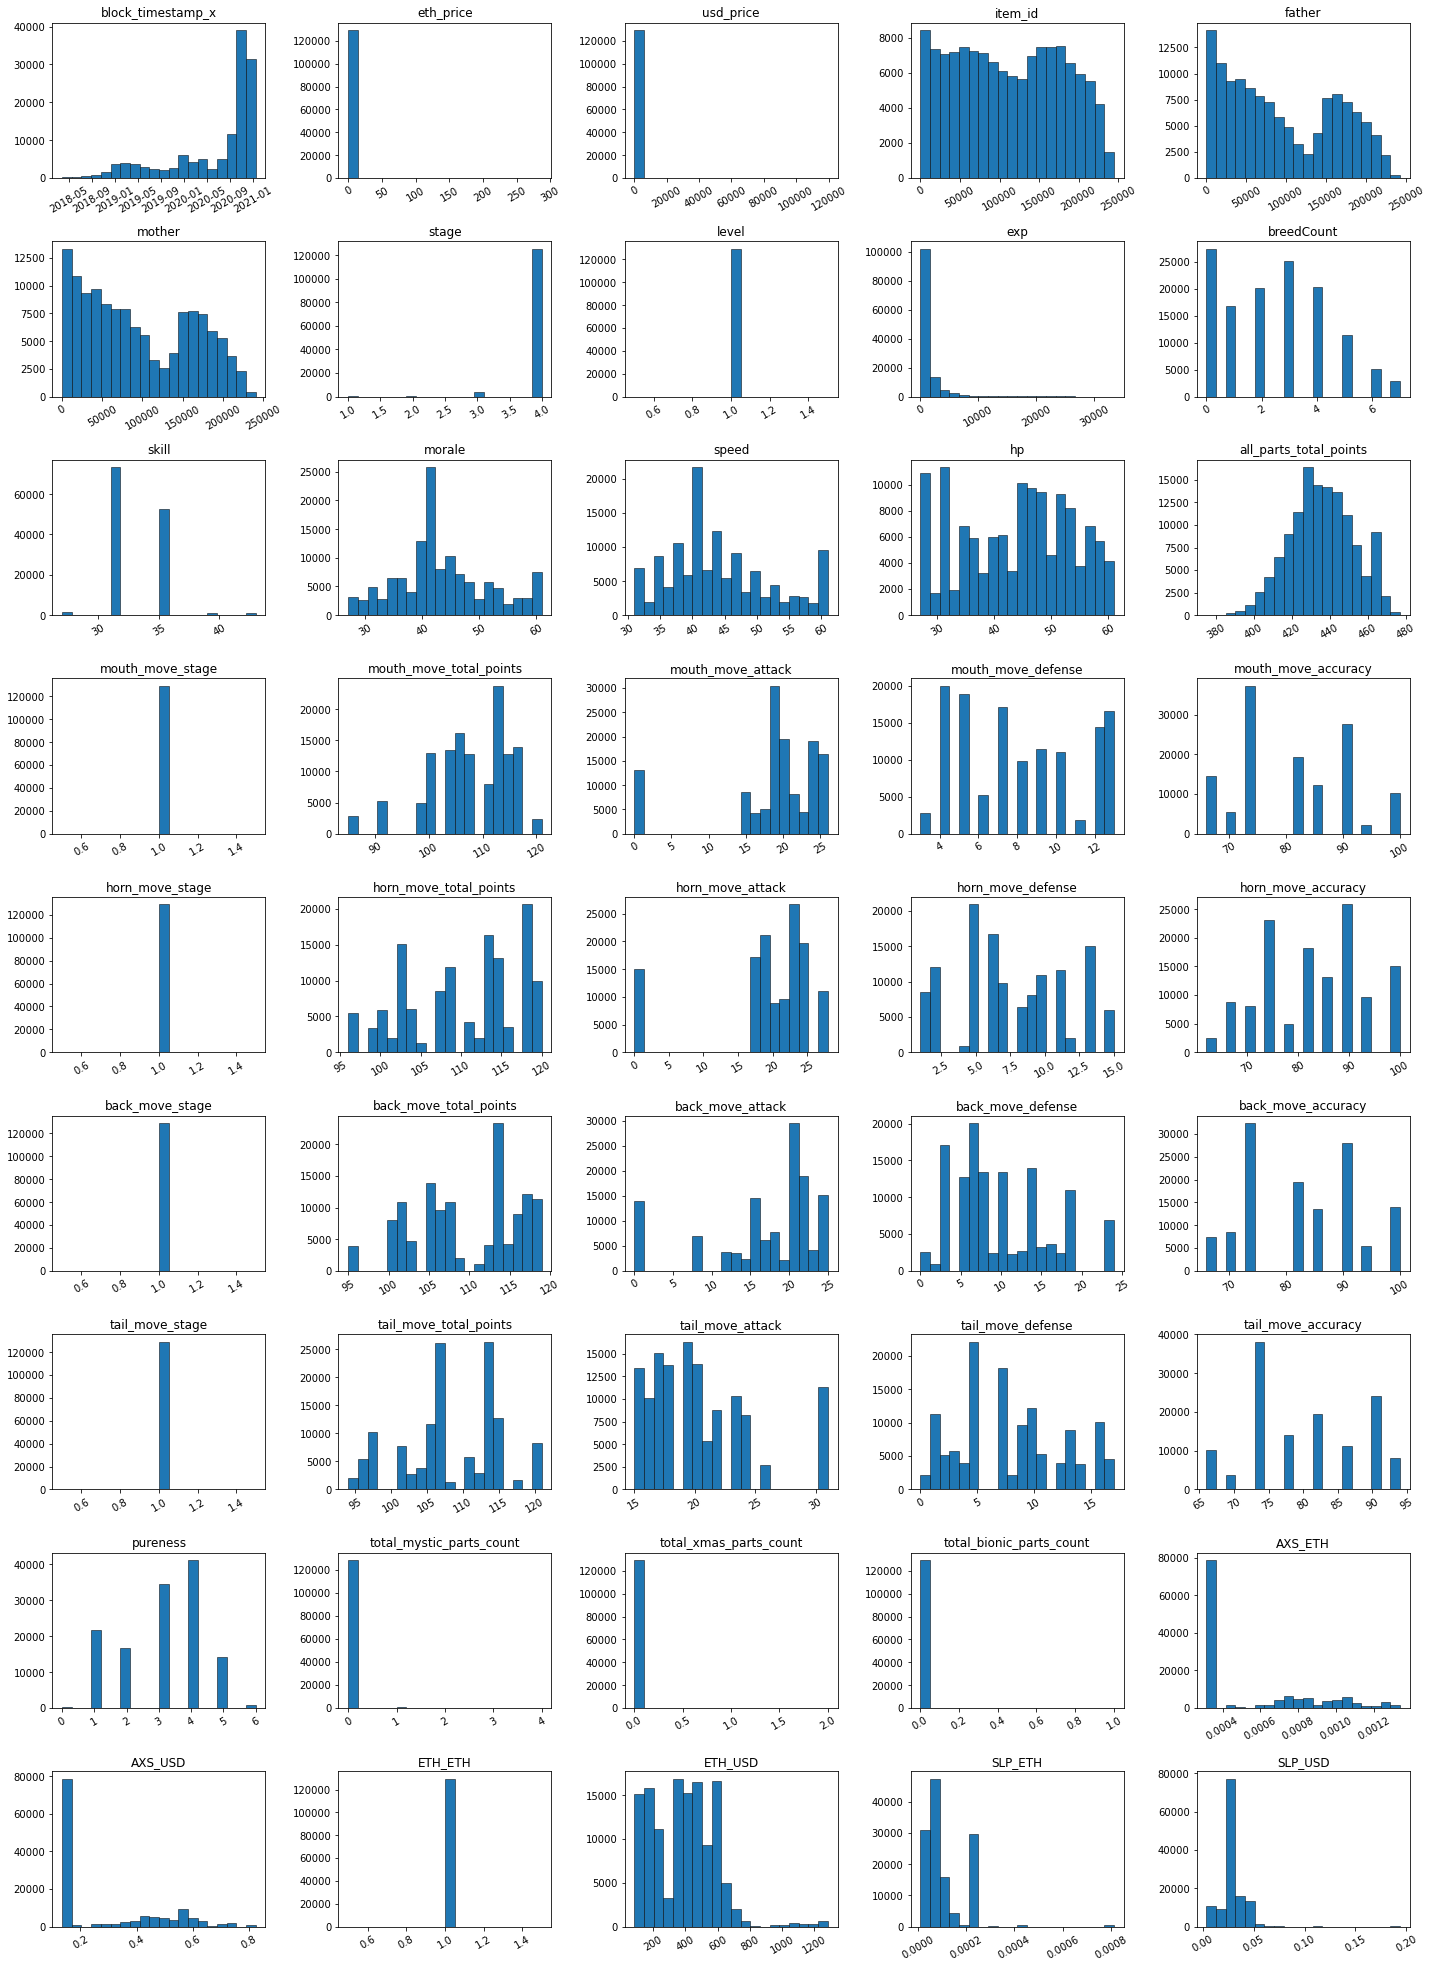

In [8]:
dataset.hist(bins=20, edgecolor='black', xrot=30,
             layout=(10,5), linewidth=.5, grid=False,
             figsize = (20,30))
plt.tight_layout()

  eth_price                 1.00000   |   usd_price                 1.00000
  usd_price                 0.96433   |   eth_price                 0.96433
  total_mystic_parts_count  0.45674   |   total_mystic_parts_count  0.38925
  is_having_mystic_part     0.28572   |   is_having_mystic_part     0.23942
  is_horn_mystic            0.16366   |   is_horn_mystic            0.14062
  is_back_mystic            0.16354   |   is_back_mystic            0.13969
  is_tail_mystic            0.15443   |   is_tail_mystic            0.13281
  is_ears_mystic            0.14083   |   is_eyes_mystic            0.12918
  is_eyes_mystic            0.13917   |   is_ears_mystic            0.11348
  is_mouth_mystic           0.12637   |   is_mouth_mystic           0.10288
  exp                       0.11121   |   exp                       0.09090
  is_having_bionic_part     0.09883   |   total_bionic_parts_count  0.07355
  total_bionic_parts_count  0.09883   |   is_having_bionic_part     0.07355
  item_id   

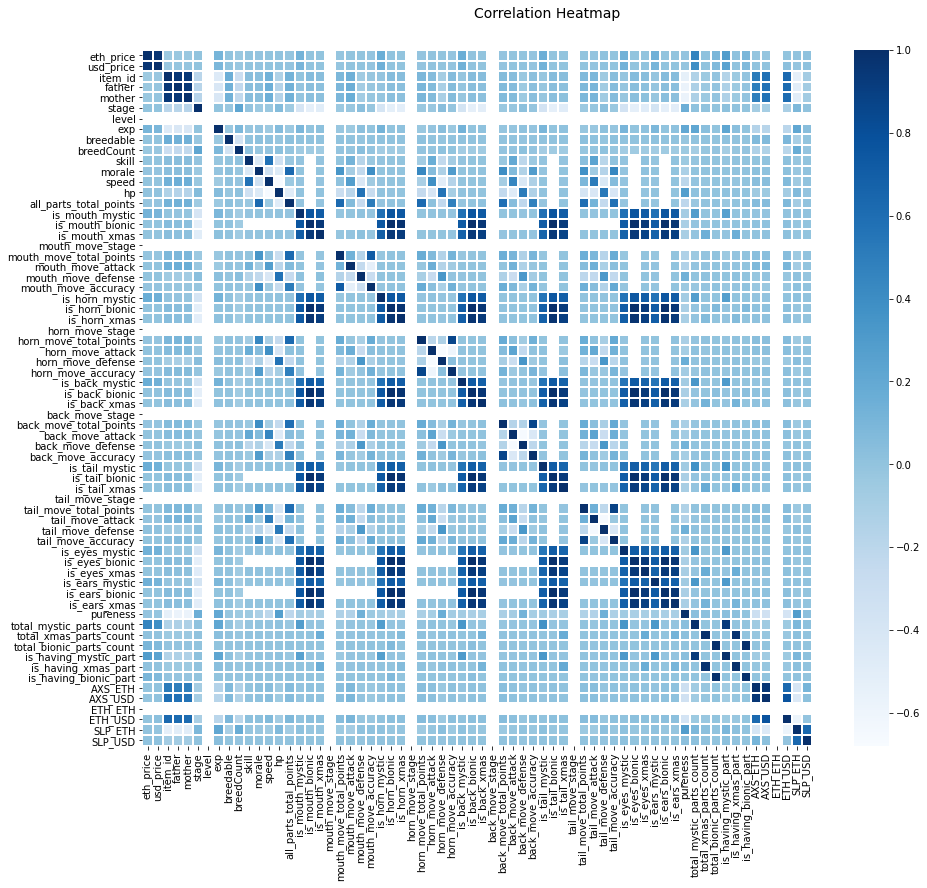

In [9]:
corr = dataset.corr()
top10_eth = corr.sort_values(by=['eth_price'], key=abs, ascending=False).eth_price[:25]
top10_usd = corr.sort_values(by=['usd_price'], key=abs, ascending=False).usd_price[:25]

for (a1,a2), (b1,b2) in zip(top10_eth.iteritems(), top10_usd.iteritems()):
    print(f"{'':>2}{a1:25} {a2:<.5f}   |   {b1:25} {b2:<.5f}" )
    
    
f, ax = plt.subplots(figsize=(15, 12))
hm = sns.heatmap(round(corr,5), ax=ax, cmap="Blues",
                 xticklabels=True, yticklabels=True,
                 linewidths=.05, #annot=True, fmt='.2f'
                 )
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Heatmap', fontsize=14)

In [10]:
# continuous_num_feats = ['eth_price','usd_price','AXS_ETH','AXS_USD','ETH_ETH','ETH_USD','SLP_ETH','SLP_USD']
# discrete_num_feats = []
# cat_feats=[]
#
# for col in dataset.columns:
#     if col not in continuous_num_feats:
#         if pd.api.types.is_categorical_dtype(dataset[col]) or pd.api.types.is_bool_dtype(dataset[col]):
#             cat_feats.append(col)
#         elif pd.api.types.is_numeric_dtype(dataset[col]):
#             discrete_num_feats.append(col)
#         else:
#             pass
#     else:
#         continue



# for col in lst:
#     if pd.api.types.is_categorical_dtype(dataset[col]):
#         print(col, 'categorical_feat')
#         plt.scatter(dataset.dropna()[col], dataset.dropna()['usd_price'],
#                     alpha=0.5, s=7)
#     else:
#         print(col)
#         sns.jointplot(x=col, y='usd_price', data=dataset, hue='class',
#                       ratio=5, alpha=0.5, s=7)
#         plt.show()

In [11]:
# from sklearn.preprocessing import MinMaxScaler
# scaled_price = MinMaxScaler().fit_transform(dataset[['usd_price','eth_price']])
# scaled_df = dataset.copy()
# scaled_df.usd_price = scaled_price[:,0]
# scaled_df.eth_price = scaled_price[:,1]
#
# scaled_df = pd.DataFrame(columns=discrete_num_feats+cat_feats+['usd_price','eth_price'], index=dataset.index, data=scaled_df)
# df_plot = pd.melt(scaled_df, id_vars=discrete_num_feats+cat_feats, value_vars=['usd_price','eth_price'])
#
#
# fig, axes = plt.subplots(5, 2, figsize=(20, 20))
# cnt = 0
# for col in discrete_num_feats:
#     if cnt <10:
#         if 1<dataset[col].nunique()<=8:
#             sns.boxplot(x=col, y="value", data=df_plot, hue="variable", width=0.4,
#                         palette={"usd_price": "grey", "eth_price": "white"},
#                         showfliers=False,
#                         ax=axes[cnt//2, cnt%2])
#             axes[cnt//2, cnt%2].set_title(col)
#             axes[cnt//2, cnt%2].tick_params(axis='x', rotation=30)
#
#             cnt+=1
#
# fig, axes = plt.subplots(5, 3, figsize=(20, 20))
# cnt = 0
# for col in cat_feats:
#     if cnt <15:
#         if 1<dataset[col].nunique()<=8:
#             sns.boxplot(x=col, y="value", data=df_plot, hue="variable", width=0.4,
#                         palette={"usd_price": "grey", "eth_price": "white"},
#                         showfliers=False,
#                         ax=axes[cnt//3, cnt%3])
#             axes[cnt//3, cnt%3].set_title(col)
#             axes[cnt//3, cnt%3].tick_params(axis='x', rotation=30)
#
#             cnt+=1

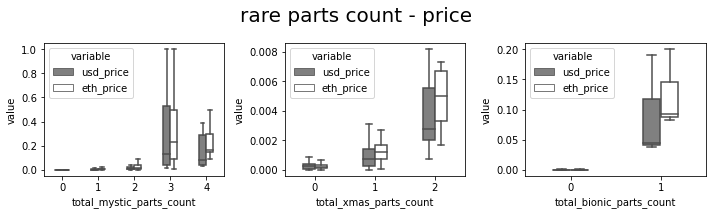

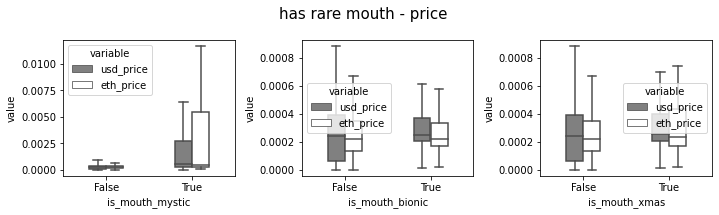

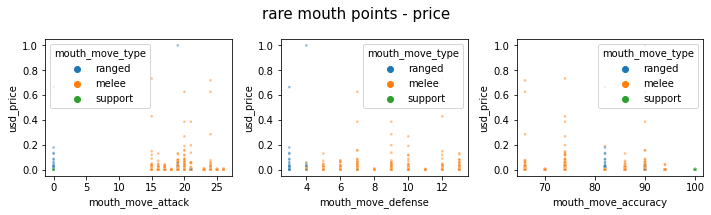

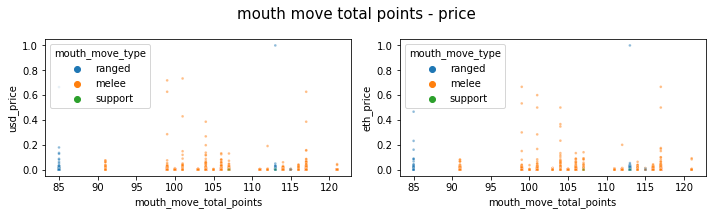

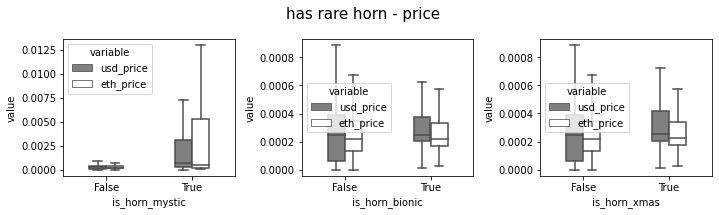

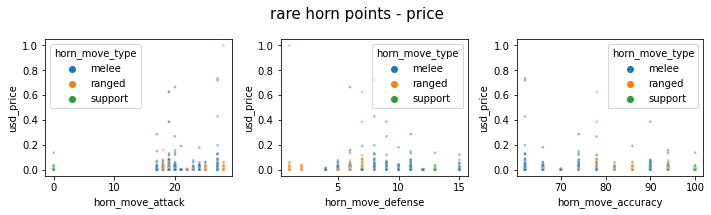

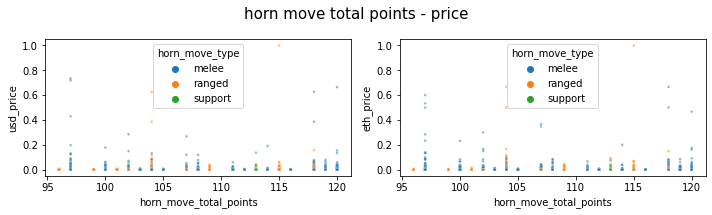

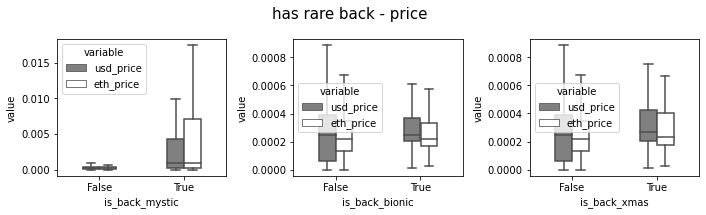

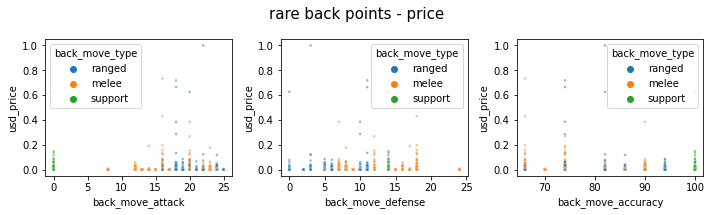

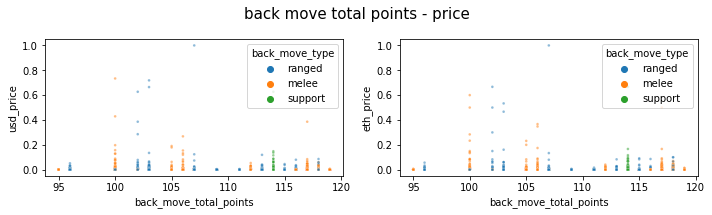

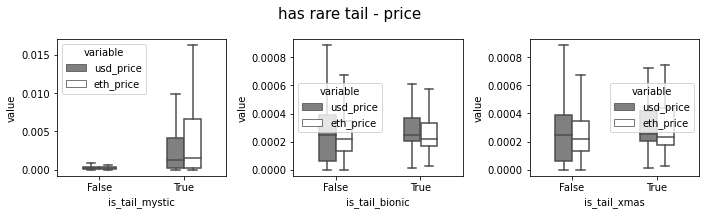

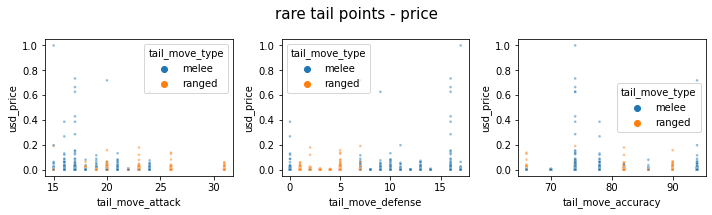

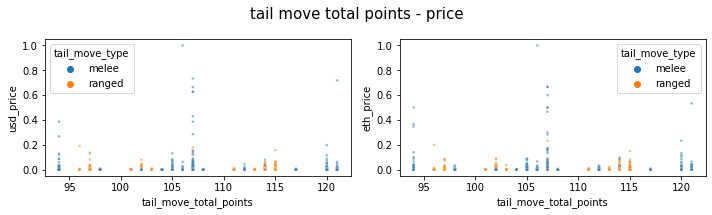

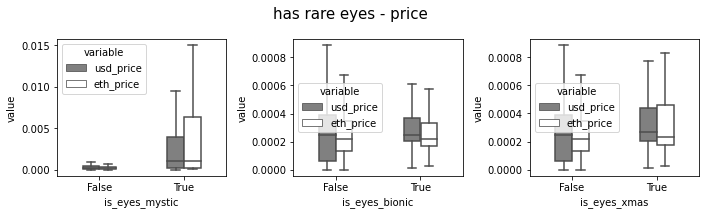

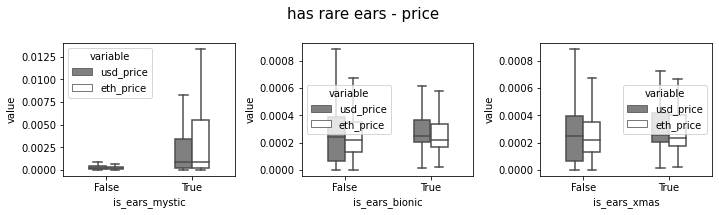

In [12]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaled_price = MinMaxScaler().fit_transform(dataset[['usd_price','eth_price']])
scaled_df = dataset.copy()
scaled_df.usd_price = scaled_price[:,0]
scaled_df.eth_price = scaled_price[:,1]
scaled_df = pd.DataFrame(columns=dataset.columns, index=dataset.index, data=scaled_df)
id_vars_lst = [x for x in dataset.columns if x not in ['usd_price','eth_price']]
df_plot_melt = pd.melt(scaled_df, id_vars=id_vars_lst, value_vars=['usd_price','eth_price'])



fig, axes = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle('rare parts count - price', fontsize=20)
for cnt, col in enumerate(['total_mystic_parts_count','total_xmas_parts_count','total_bionic_parts_count']):
    sns.boxplot(x=col, y="value", data=df_plot_melt, hue="variable", width=0.4,
                    palette={"usd_price": "grey", "eth_price": "white"},
                    showfliers=False,
                    ax=axes[cnt])
    fig.tight_layout()
    # axes[cnt].tick_params(axis='x', rotation=30)

for part in ['mouth','horn','back','tail','eyes','ears']:
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    fig.suptitle(f"has rare {part} - price", fontsize=15)
    for cnt, col in enumerate([f"is_{part}_mystic",f"is_{part}_bionic",f"is_{part}_xmas"]):
        sns.boxplot(x=col, y="value", data=df_plot_melt, hue="variable", width=0.4,
                    palette={"usd_price": "grey", "eth_price": "white"},
                    showfliers=False,
                    ax=axes[cnt])
    fig.tight_layout()

    if part not in ['eyes','ears']:
        fig, axes = plt.subplots(1, 3, figsize=(10, 3))
        fig.suptitle(f"rare {part} points - price", fontsize=15)
        for cnt, col in enumerate([f"{part}_move_attack",f"{part}_move_defense",f"{part}_move_accuracy"]):
            sns.scatterplot(x=col, y='usd_price', data=scaled_df, hue=f'{part}_move_type',
                          alpha=0.5, s=7, ax=axes[cnt])
        fig.tight_layout()

        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        fig.suptitle(f"{part} move total points - price", fontsize=15)
        for cnt, p in enumerate(['usd_price','eth_price']):
            sns.scatterplot(x=f"{part}_move_total_points", y=p, data=scaled_df, hue=f'{part}_move_type',
                              alpha=0.5, s=7, ax=axes[cnt])
        fig.tight_layout()

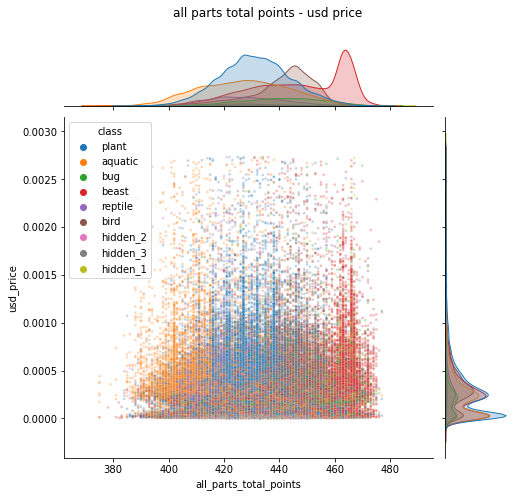

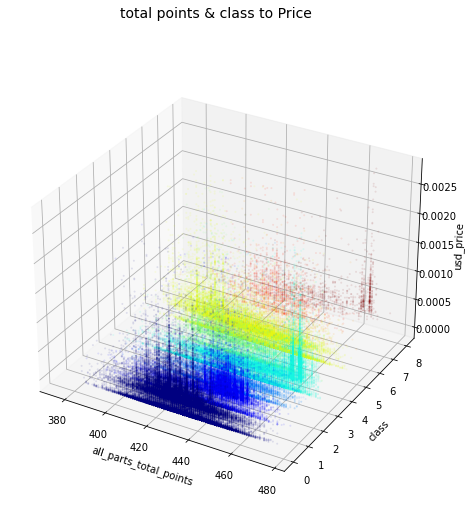

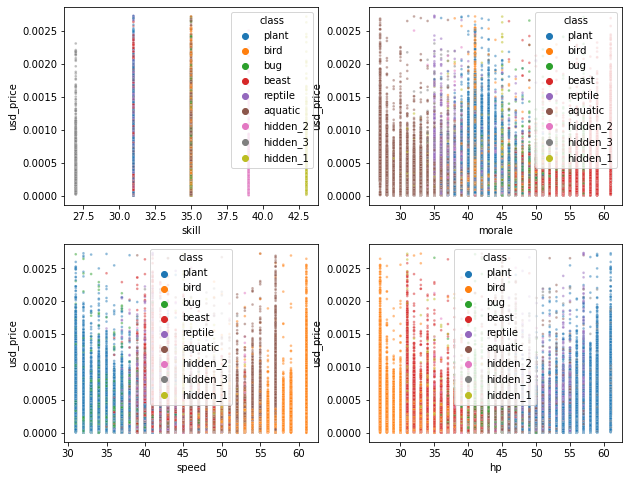

In [13]:
scaled_price = MinMaxScaler().fit_transform(dataset[['usd_price','eth_price']])
scaled_df = dataset.copy()
scaled_df.usd_price = scaled_price[:,0]
scaled_df.eth_price = scaled_price[:,1]
scaled_df = pd.DataFrame(columns=dataset.columns, index=dataset.index, data=scaled_df)

thold = scaled_df.usd_price.quantile(0.99)
scaled_df = scaled_df[scaled_df.usd_price<=thold]
m=sns.jointplot(x='all_parts_total_points', y='usd_price', data=scaled_df, hue='class',
                          ratio=5, alpha=0.3, s=7, height=7)
m.fig.suptitle('all parts total points - usd price')
m.fig.subplots_adjust(top=0.9)
plt.show()



fig = plt.figure(figsize=(10, 8))
t = fig.suptitle('total points & class to Price', fontsize=14)
ax = fig.add_subplot(111, projection='3d')
scaled_df.dropna(inplace=True)
class_lst = scaled_df['class'].unique().tolist()

xs = scaled_df['all_parts_total_points'].tolist()
ys = [class_lst.index(k) for k in scaled_df['class'].tolist()]
zs = scaled_df['usd_price'].tolist()

ax.scatter(xs, ys, zs, alpha=0.1, c=ys, edgecolors='none',cmap='jet', s=4)

ax.set_xlabel('all_parts_total_points')
ax.set_ylabel('class')
ax.set_zlabel('usd_price')

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for cnt, col in enumerate(['skill','morale','speed','hp']):
    sns.scatterplot(x=col, y='usd_price', data=scaled_df, hue='class',
                          alpha=0.5, s=7, ax=axes[cnt//2,cnt%2])

# for cnt, col in enumerate(['stage','exp','breedcount','skill','morale','speed','hp','pureness']):

Text(0.5, 0, 'usd_price')

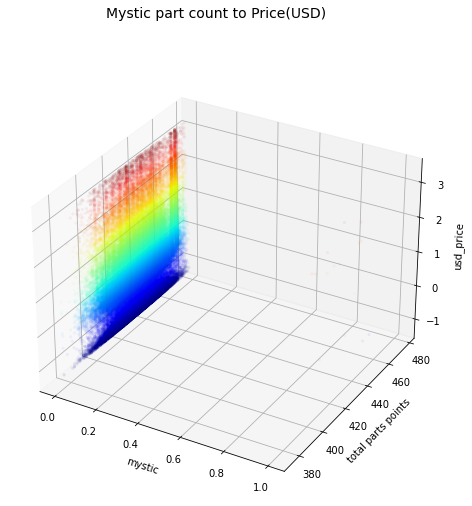

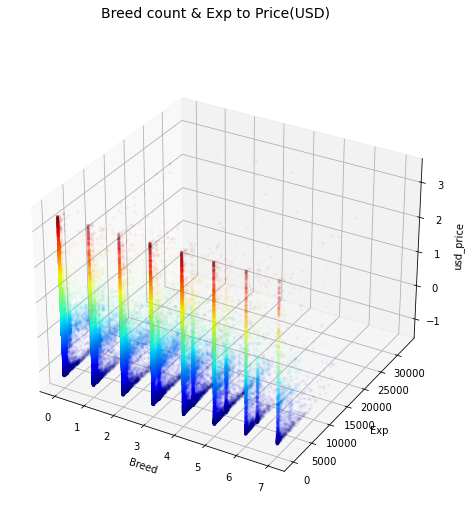

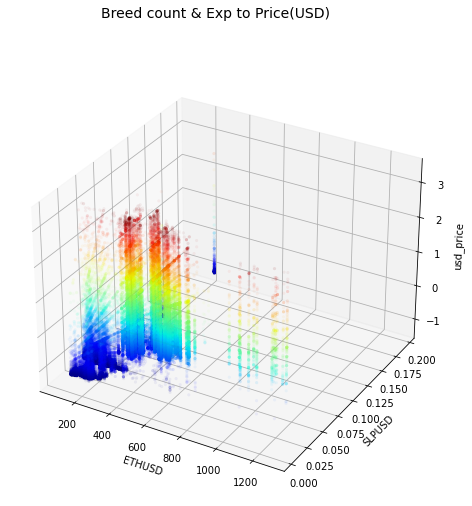

In [14]:
scaled_df = dataset.copy()
scaled_df = scaled_df[scaled_df.usd_price < scaled_df.usd_price.quantile(0.95)]
scaled_df.usd_price = StandardScaler().fit_transform(scaled_df[['usd_price']])
scaled_df = pd.DataFrame(columns=dataset.columns, index=dataset.index, data=scaled_df)


#total mystic parts count
#total_bionic_parts_count
fig = plt.figure(figsize=(10, 8))
t = fig.suptitle('Mystic part count to Price(USD)', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = scaled_df.total_mystic_parts_count.tolist()
ys = scaled_df.all_parts_total_points.tolist()
zs = scaled_df['usd_price'].tolist()
ax.scatter(xs, ys, zs, alpha=0.05, c=zs, edgecolors='none',cmap='jet', s=10)

ax.set_xlabel('mystic')
ax.set_ylabel('total parts points')
ax.set_zlabel('usd_price')
#exp
#breedcount
fig = plt.figure(figsize=(10, 8))
t = fig.suptitle('Breed count & Exp to Price(USD)', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = scaled_df.breedCount.tolist()
ys = scaled_df.exp.tolist()
zs = scaled_df['usd_price'].tolist()
ax.scatter(xs, ys, zs, alpha=0.05, c=zs, edgecolors='none',cmap='jet', s=10)

ax.set_xlabel('Breed')
ax.set_ylabel('Exp')
ax.set_zlabel('usd_price')

#eth usd
#slp usd
fig = plt.figure(figsize=(10, 8))
t = fig.suptitle('Breed count & Exp to Price(USD)', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = scaled_df.ETH_USD.tolist()
ys = scaled_df.SLP_USD.tolist()
zs = scaled_df['usd_price'].tolist()
ax.scatter(xs, ys, zs, alpha=0.05, c=zs, edgecolors='none',cmap='jet', s=10)

ax.set_xlabel('ETHUSD')
ax.set_ylabel('SLPUSD')
ax.set_zlabel('usd_price')

In [17]:
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split,TimeSeriesSplit,cross_val_score
# from sklearn.metrics import mean_absolute_percentage_error

# #basemodel
# reg = LinearRegression()
# reg2 = RandomForestRegressor(n_estimators=100,
#                              criterion='mae',
#                              max_features=0.7,
#                              max_depth=8,
#                              n_jobs=-1, verbose=True)
# dataset.sort_values(by='block_timestamp_x', inplace=True)
# basemodel_dataset = dataset[['total_mystic_parts_count','total_bionic_parts_count','total_xmas_parts_count',
#                             'all_parts_total_points',
#                             'skill','morale','speed','hp',
#                             'breedCount','exp','pureness',
#                             'usd_price']]
# basemodel_dataset.dropna(inplace=True)



# df_train, df_test = train_test_split(basemodel_dataset,train_size=0.7, test_size=0.3, shuffle=False)
# x_train = df_train.drop('usd_price', axis=1)
# y_train = df_train.usd_price

# scores = cross_val_score(reg, x_train, y_train,
#                          scoring='neg_mean_absolute_percentage_error',
#                          cv=TimeSeriesSplit(5))
# print(scores)
# print(f'basemodel timesplit cv score(MAPE): {-sum(scores)/len(scores):.4f}')
# scores2 = cross_val_score(reg2, x_train, y_train,
#                          scoring='neg_mean_absolute_percentage_error',
#                          cv=TimeSeriesSplit(5))
# print(scores2)
# print(f'basemodel timesplit cv score(MAPE): {-sum(scores2)/len(scores2):.4f}')

In [19]:
import catboost as cgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split,TimeSeriesSplit,cross_val_score


seed=42

dataset.sort_values(by='block_timestamp_x', inplace=True)
reg_dataset = dataset[[
    'class',
    'breedCount','pureness',
    'skill','morale','speed','hp',
    'all_parts_total_points',
    'total_mystic_parts_count',
#     'total_xmas_parts_count',
#     'total_bionic_parts_count',
    'ETH_USD','SLP_USD',
    'usd_price']]



cat_feats =['class']
for col in cat_feats:
    reg_dataset.loc[reg_dataset[col].isna(),col]='NaN'

print(reg_dataset.head())


df_train, df_rest = train_test_split(reg_dataset,train_size=0.7, test_size=0.3, shuffle=False)
df_valid, df_test = train_test_split(df_rest,train_size=0.5, test_size=0.5, shuffle=False)

x_train = df_train.drop('usd_price', axis=1)
y_train = df_train.usd_price
cgbtrainDataset = cgb.Pool(data=x_train, label=y_train, cat_features=cat_feats)

def cat_eval(depth, subsample, min_data_in_leaf, l2_leaf_reg):
  params = {"task_type":"GPU",
            "devices":'0',
            "learning_rate": 5e-2,
            "loss_function": "MAPE",
            "eval_metric": "MAPE",
            "subsample": min(subsample, 1),
            "depth": int(depth),
            'min_data_in_leaf':int(min_data_in_leaf),
            "l2_leaf_reg" : int(l2_leaf_reg),
            "use_best_model": True,
            "one_hot_max_size":2,
            'simple_ctr':'FloatTargetMeanValue', 
            'combinations_ctr':'FloatTargetMeanValue',
            'model_size_reg':1
           }


  scores = cgb.cv(pool=cgbtrainDataset,
                  params=params,
                  num_boost_round=99999,
                  early_stopping_rounds=100,
                  folds=TimeSeriesSplit(5),
                  stratified=False,
                  seed=seed,
                  verbose_eval=False)

  return -np.min(scores['test-MAPE-mean'])



cgbBO = BayesianOptimization(cat_eval,
                             {'depth': (5, 12),
                              'subsample': (0.5, 1.0),
                              'min_data_in_leaf': (2, 30),
                              'l2_leaf_reg': (2, 30),
                             },
                             random_state=seed)



print(f"CatBoost bayesian optimization")
cgbBO.maximize(init_points=3, n_iter=5)
best_score_cgb = max(cgbBO.res, key=lambda x:x['target'])['target']
best_params_cgb = max(cgbBO.res, key=lambda x:x['target'])['params']
print(f'best MAPE score: {-best_score_cgb}')
print(best_params_cgb)


     class  breedCount  pureness  skill  morale  speed    hp  \
0      bug           0         5   35.0    50.0   36.0  43.0   
1    plant           1         5   31.0    41.0   38.0  54.0   
2  aquatic           7         3   35.0    30.0   49.0  50.0   
3    plant           3         4   31.0    39.0   38.0  56.0   
4  aquatic           0         4   35.0    31.0   50.0  48.0   

   all_parts_total_points  total_mystic_parts_count   ETH_USD   SLP_USD  \
0                   425.0                         1  519.4856  0.031432   
1                   423.0                         0  519.4856  0.031432   
2                   428.0                         0  519.4856  0.031432   
3                   396.0                         0  519.4856  0.031432   
4                   422.0                         1  519.4856  0.031432   

    usd_price  
0  497.407462  
1   60.683710  
2   74.428016  
3   74.225611  
4  223.563925  
CatBoost bayesian optimization
|   iter    |  target   |   depth   |

In [20]:

best_params_cgb.update({"task_type": "GPU",
                        "devices": '0',
                        "learning_rate": 5e-2,
                        "loss_function": "MAPE",
                        "eval_metric": "MAPE",
                        "use_best_model": True,
                        "one_hot_max_size":2,
                        'simple_ctr':'FloatTargetMeanValue', 
                        'combinations_ctr':'FloatTargetMeanValue',
                        'model_size_reg':1
                       })
best_params_cgb['subsample'] =  min(best_params_cgb['subsample'], 1)
best_params_cgb['depth'] =  int(best_params_cgb['depth'])
best_params_cgb['min_data_in_leaf'] =  int(best_params_cgb['min_data_in_leaf'])
best_params_cgb['l2_leaf_reg'] =  int(best_params_cgb['l2_leaf_reg'])




reg = cgb.CatBoostRegressor(**best_params_cgb, num_boost_round=99999,
                            early_stopping_rounds=100, verbose=1)
reg.fit(X=df_train.drop('usd_price', axis=1), y=df_train.usd_price,
        cat_features=cat_feats, eval_set=[(df_valid.drop('usd_price', axis=1), df_valid.usd_price)],
        use_best_model=True, verbose=1000,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7575542	test: 0.9380256	best: 0.9380256 (0)	total: 12.8ms	remaining: 21m 20s
1000:	learn: 0.7186587	test: 0.9121266	best: 0.9121266 (1000)	total: 8.59s	remaining: 14m 9s
2000:	learn: 0.7055832	test: 0.8920747	best: 0.8920747 (2000)	total: 15.9s	remaining: 12m 56s
3000:	learn: 0.6908806	test: 0.8690942	best: 0.8690942 (3000)	total: 24.4s	remaining: 13m 9s
4000:	learn: 0.6769444	test: 0.8452286	best: 0.8452286 (4000)	total: 33.8s	remaining: 13m 31s
5000:	learn: 0.6638048	test: 0.8224462	best: 0.8224462 (5000)	total: 43s	remaining: 13m 37s
6000:	learn: 0.6495265	test: 0.7978539	best: 0.7978539 (6000)	total: 52.3s	remaining: 13m 39s
7000:	learn: 0.6363261	test: 0.7747893	best: 0.7747893 (7000)	total: 1m 1s	remaining: 13m 37s
8000:	learn: 0.6232794	test: 0.7517638	best: 0.7517638 (8000)	total: 1m 10s	remaining: 13m 34s
9000:	learn: 0.6107337	test: 0.7294622	best: 0.7294622 (9000)	total: 1m 19s	remaining: 13m 28s
10000:	learn: 0.5979806	test: 0.7065594	best: 0.7065594 (10000)	tot

In [21]:
for feat, score in zip(reg_dataset.columns, reg.get_feature_importance()):
    print(f'{feat:30}: {score:.4f}')

class                         : 4.7090
breedCount                    : 0.9707
pureness                      : 10.5638
skill                         : 0.0000
morale                        : 0.1353
speed                         : 0.9000
hp                            : 1.1330
all_parts_total_points        : 0.2520
total_mystic_parts_count      : 0.0000
ETH_USD                       : 51.7129
SLP_USD                       : 29.6233


In [22]:
train_score = mean_absolute_percentage_error(df_train.usd_price,reg.predict(df_train.drop('usd_price',axis=1))) 
valid_score = mean_absolute_percentage_error(df_valid.usd_price,reg.predict(df_valid.drop('usd_price',axis=1))) 
test_score = mean_absolute_percentage_error(df_test.usd_price,reg.predict(df_test.drop('usd_price',axis=1))) 

print(f'train(MAPE): {train_score:.4f}')
print(f'valid(MAPE): {valid_score:.4f}')
print(f'test(MAPE) : {test_score:.4f}')

train(MAPE): 124682624.7751
valid(MAPE): 0.3242
test(MAPE) : 0.3283


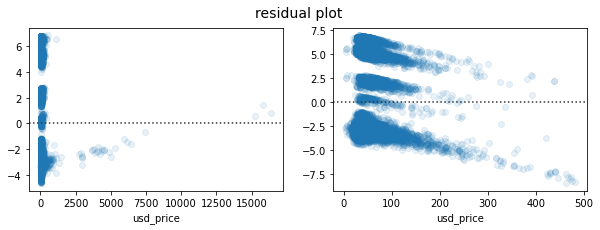

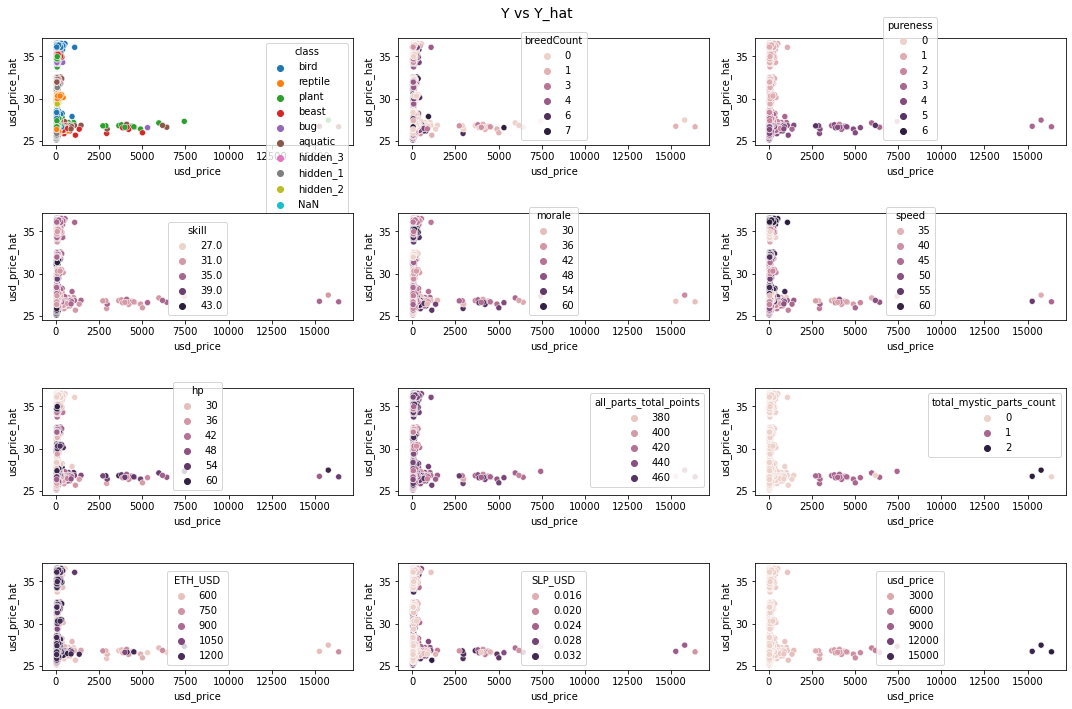

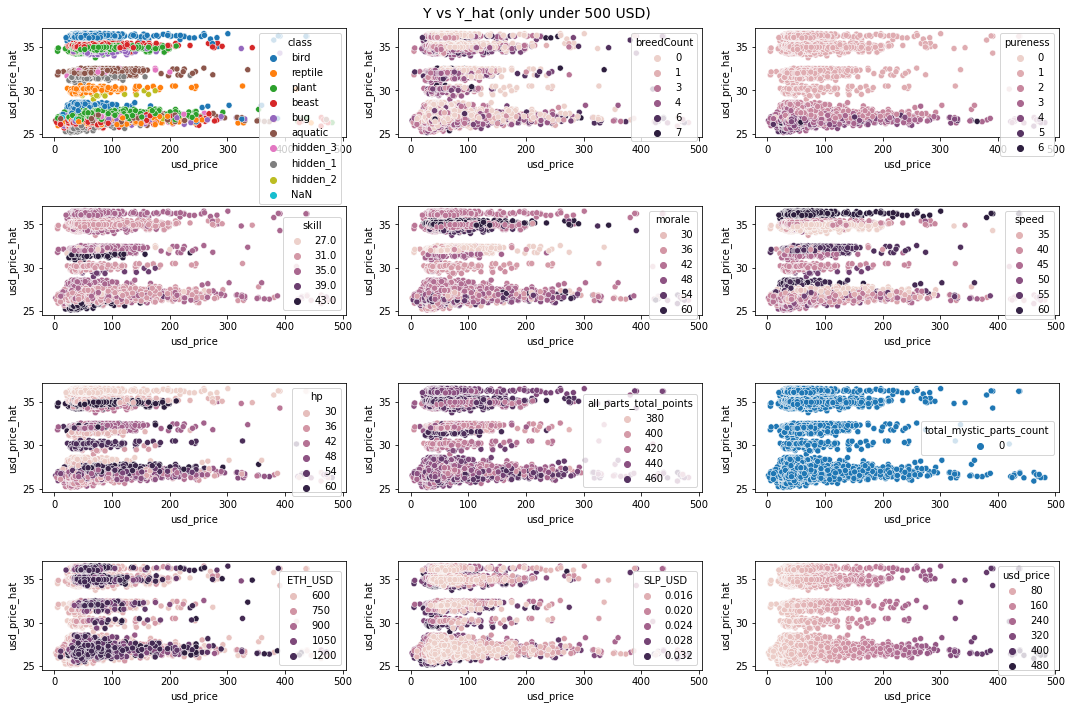

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('residual plot', fontsize=14)
sns.residplot(df_test.usd_price, reg.predict(df_test.drop('usd_price',axis=1)), 
              scatter_kws={'alpha':0.1}, ax= axes[0])
sns.residplot(df_test[df_test.usd_price<500].usd_price, reg.predict(df_test[df_test.usd_price<500].drop('usd_price',axis=1)), 
              scatter_kws={'alpha':0.1}, ax=axes[1])


plot_df = df_test.copy()
plot_df['usd_price_hat'] = reg.predict(plot_df.drop('usd_price',axis=1))

fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Y vs Y_hat', fontsize=14)
for i in range(12):
    sns.scatterplot(x='usd_price', y='usd_price_hat', data= plot_df,
                    hue=plot_df.columns[i], ax=axes[i//3, i%3])
fig.tight_layout()




plot_df = plot_df[plot_df.usd_price<500]
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Y vs Y_hat (only under 500 USD)', fontsize=14)
for i in range(12):
    sns.scatterplot(x='usd_price', y='usd_price_hat', data= plot_df,
                    hue=plot_df.columns[i], ax=axes[i//3, i%3])
fig.tight_layout()


In [26]:
submission = item.sort_values('block_timestamp').drop_duplicates('item_id',keep='last')

submission['ETH_USD'] = exchange.iloc[-1].ETH_USD
submission['SLP_USD'] = exchange.iloc[-1].SLP_USD
submission

,item_id,block_timestamp,block_date,father,fatherClass,mother,motherClass,class,stage,level,...,is_ears_xmas,pureness,total_mystic_parts_count,total_xmas_parts_count,total_bionic_parts_count,is_having_mystic_part,is_having_xmas_part,is_having_bionic_part,ETH_USD,SLP_USD
329580,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d_131809,2020-10-20 03:37:13.737613+00:00,2020-10-20,114487,plant,109374,plant,plant,4,1,...,False,2,0,0,0,False,False,False,1546.499621,0.057005
49797,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d_158969,2020-10-20 03:37:15.962951+00:00,2020-10-20,149171,plant,148339,beast,plant,4,1,...,False,3,0,0,0,False,False,False,1546.499621,0.057005
232344,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d_78034,2020-10-20 03:37:17.179364+00:00,2020-10-20,65031,bird,65852,bird,bird,4,1,...,False,4,0,0,0,False,False,False,1546.499621,0.057005
388570,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d_65639,2020-10-20 03:37:31.570282+00:00,2020-10-20,33148,plant,40783,reptile,reptile,4,1,...,False,4,0,0,0,False,False,False,1546.499621,0.057005
285932,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d_131003,2020-10-20 03:57:00.546611+00:00,2020-10-20,111930,reptile,94113,reptile,reptile,4,1,...,False,3,0,0,0,False,False,False,1546.499621,0.057005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385164,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d_6211,2021-03-06 22:02:21.364408+00:00,2021-03-06,1408,beast,5717,beast,beast,4,1,...,False,5,0,0,0,False,False,False,1546.499621,0.057005
169564,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d_6177,2021-03-06 22:02:21.565907+00:00,2021-03-06,5669,beast,5667,plant,beast,4,1,...,False,3,0,0,0,False,False,False,1546.499621,0.057005
515579,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d_6186,2021-03-06 22:02:21.766588+00:00,2021-03-06,2896,plant,4730,reptile,plant,4,1,...,False,2,0,0,0,False,False,False,1546.499621,0.057005
373851,0xf5b0a3efb8e8e4c201e2a935f110eaaf3ffecb8d_6172,2021-03-06 22:02:21.959060+00:00,2021-03-06,5652,aquatic,5711,bug,aquatic,4,1,...,False,3,0,0,0,False,False,False,1546.499621,0.057005


In [27]:
cols = reg_dataset.columns
submission = submission[cols.drop('usd_price')]
submission

,class,breedCount,pureness,skill,morale,speed,hp,all_parts_total_points,total_mystic_parts_count,ETH_USD,SLP_USD
329580,plant,2,2,31,39,37,57,434,0,1546.499621,0.057005
49797,plant,3,3,31,49,38,46,456,0,1546.499621,0.057005
232344,bird,2,4,35,42,56,31,430,0,1546.499621,0.057005
388570,reptile,2,4,31,40,40,53,425,0,1546.499621,0.057005
285932,reptile,2,3,31,38,42,53,409,0,1546.499621,0.057005
...,...,...,...,...,...,...,...,...,...,...,...
385164,beast,7,5,31,51,44,38,451,0,1546.499621,0.057005
169564,beast,1,3,31,54,41,38,436,0,1546.499621,0.057005
515579,plant,6,2,31,37,35,61,417,0,1546.499621,0.057005
373851,aquatic,5,3,35,39,46,44,447,0,1546.499621,0.057005


In [28]:
for col in cat_feats:
    submission.loc[submission[col].isna(),col]='NaN'
submission['TARGET']=reg.predict(submission)
submission=submission[['TARGET']].reset_index()
submission.columns=['ID','TARGET']
submission=submission.sort_values(by='ID')

In [29]:
submission.to_csv('Result_1.csv', index=False)